1. 팩터 생성 중... (Momentum, Volatility, Stochastic, WillR, RSI)
2. 데이터 분할 (Train: ~19년 / Val: 20~21년 / Test: 22년~)
3. XGBoost 모델 학습 시작...
   -> 학습 완료!
4. Test 데이터 예측 및 랭킹 산출 중...

🚀 [최종 전략] 역발상(청개구리) + 60일 시장필터 + 손절매
   - 매매 주기: 2주(10거래일) 1회
   - 거래 비용: 0.2% 적용
   - 손절 매도: -5% 도달 시
1. 누적 수익률 (Total Return) : 52.78%
2. 연환산 수익률 (CAGR)       : 15.54%
3. 최대 낙폭 (MDD)            : -10.38%
------------------------------------------------------------


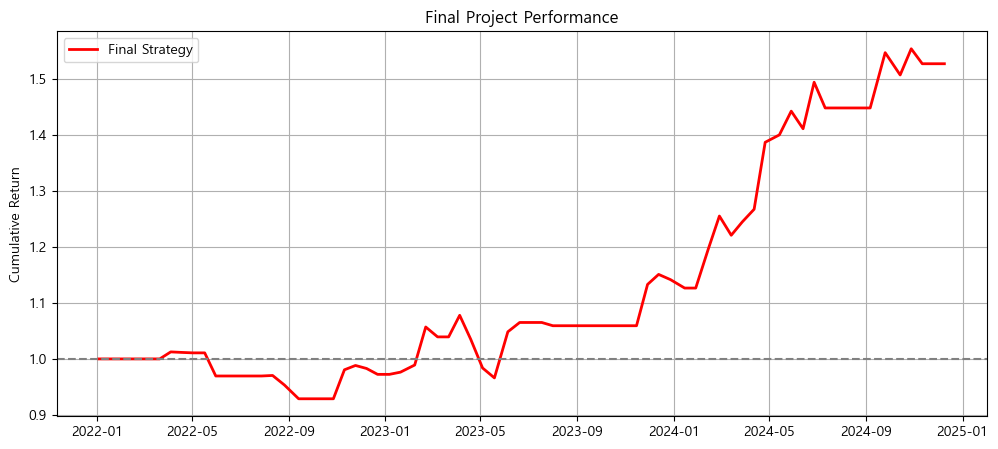


📅 [2024-12-13] AI 추천 종목 (Bottom 10 Pick)
        ticker       종가  Score   Rank
41775   001570    26200   0.50  200.0
167133  010130  1225000   1.00  199.0
267911  036460    32650   1.50  198.0
299865  052690    51100   2.00  197.0
253163  034020    17240   2.50  196.0
287575  047050    38950   3.00  195.0
353755  105560    85000   3.50  194.0
400555  192820   148800   4.25  192.0
430097  302440    56000   4.25  192.0
78645   004000    39700   6.00  187.0


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import platform

# -----------------------------------------------------------------------------
# [0] 기본 설정 (폰트 등)
# -----------------------------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# [1] 데이터 로드
# =============================================================================
# ★ 아래 경로를 팀 데이터 파일 경로로 수정하세요!
df_raw = pd.read_csv("../단기모멘텀.csv", dtype={'ticker':str})

# (테스트를 위해 빈 변수 선언, 실제 사용시 위 주석을 풀고 실행하세요)
if 'df_raw' not in locals():
    print("⛔ [주의] 데이터가 로드되지 않았습니다. pd.read_csv 코드를 실행해주세요.")
    # 임시 빈 데이터프레임 (에러 방지용)
    df_raw = pd.DataFrame(columns=['date', 'ticker', '종가', '시가', '고가', '저가', '거래량', '등락률'])

# =============================================================================
# [2] 피처 엔지니어링 (과매도/반등 포착 팩터 강화)
# =============================================================================
def make_features_final(df):
    df = df.copy()
    
    # 날짜 변환 및 정렬
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['ticker', 'date'])
    
    print("1. 팩터 생성 중... (Momentum, Volatility, Stochastic, WillR, RSI)")
    
    # --- 1. 추세/변동성 지표 ---
    # F1. 10일 모멘텀 (단기 추세)
    df['F1_MOM_10D'] = df.groupby('ticker')['종가'].pct_change(periods=10)
    
    # F2. 변동성 (10일 표준편차)
    df['F2_VOLATILITY'] = df.groupby('ticker')['등락률'].rolling(10).std().reset_index(0, drop=True)
    
    # F3. 거래량 비율 (3일/10일)
    vol_3d = df.groupby('ticker')['거래량'].rolling(3).mean().reset_index(0, drop=True)
    vol_10d = df.groupby('ticker')['거래량'].rolling(10).mean().reset_index(0, drop=True)
    df['F3_VOL_RATIO'] = vol_3d / (vol_10d + 1e-9)

    # --- 2. 과매도/반등 지표 (핵심) ---
    # F4. 스토캐스틱 (Fast %K)
    n = 14
    low_n = df.groupby('ticker')['저가'].rolling(n).min().reset_index(0, drop=True)
    high_n = df.groupby('ticker')['고가'].rolling(n).max().reset_index(0, drop=True)
    df['F4_Sto_K'] = (df['종가'] - low_n) / (high_n - low_n + 1e-9) * 100
    
    # F5. 윌리엄스 %R
    df['F5_WillR'] = (high_n - df['종가']) / (high_n - low_n + 1e-9) * -100
    
    # F6. 이격도 (20일)
    ma_20 = df.groupby('ticker')['종가'].rolling(20).mean().reset_index(0, drop=True)
    df['F6_Disparity_20'] = df['종가'] / ma_20
    
    # F7. RSI (14일)
    def calc_rsi(x):
        delta = x.diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / (loss + 1e-9)
        return 100 - (100 / (1 + rs))
    df['F7_RSI_14'] = df.groupby('ticker')['종가'].transform(calc_rsi)

    # --- 3. Target 생성 (정답지) ---
    # 학습용: 10일 뒤 수익률의 '등수(Rank)' (0.0 ~ 1.0)
    df['future_return'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
    df['target_rank'] = df.groupby('date')['future_return'].rank(pct=True)
    
    # 백테스트용: 1일 수익률
    df['ret_1d'] = df.groupby('ticker')['종가'].pct_change()
    
    return df

# 팩터 생성 실행
if not df_raw.empty:
    df_processed = make_features_final(df_raw)
else:
    df_processed = pd.DataFrame()

# =============================================================================
# [3] 데이터 분할 및 모델 학습
# =============================================================================
# 모델에 사용할 피처 리스트
features = [
    'F1_MOM_10D', 'F2_VOLATILITY', 'F3_VOL_RATIO', 
    'F4_Sto_K', 'F5_WillR', 'F6_Disparity_20', 'F7_RSI_14'
]

# 결측치 제거
df_clean = df_processed.dropna(subset=['target_rank', 'future_return'] + features)

print("2. 데이터 분할 (Train: ~19년 / Val: 20~21년 / Test: 22년~)")
train_df = df_clean[(df_clean['date'] >= '2015-01-01') & (df_clean['date'] <= '2019-12-31')]
val_df   = df_clean[(df_clean['date'] >= '2020-01-01') & (df_clean['date'] <= '2021-12-31')]
test_df  = df_clean[(df_clean['date'] >= '2022-01-01') & (df_clean['date'] <= '2024-12-31')]

X_train, y_train = train_df[features], train_df['target_rank']
X_val,   y_val   = val_df[features],   val_df['target_rank']
X_test,  y_test  = test_df[features],  test_df['target_rank']

print("3. XGBoost 모델 학습 시작...")
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,    # 안정적인 학습 속도
    max_depth=5,           # 과적합 방지
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

if not X_train.empty:
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    print("   -> 학습 완료!")

# =============================================================================
# [4] 예측 및 결과 데이터셋 구성
# =============================================================================
print("4. Test 데이터 예측 및 랭킹 산출 중...")

if not X_test.empty:
    test_pred = model.predict(X_test)
    
    # 결과 저장 (백테스트에 필요한 컬럼 포함)
    result_df = test_df[['date', 'ticker', '종가', 'ret_1d', 'future_return']].copy()
    result_df.rename(columns={'future_return': 'target_return_10d'}, inplace=True)
    
    result_df['Predicted_Score'] = test_pred 

    # Score(0~100) 및 Rank(1등~N등) 산출
    result_df['Score'] = result_df.groupby('date')['Predicted_Score'].rank(pct=True) * 100
    result_df['Rank'] = result_df.groupby('date')['Predicted_Score'].rank(method='min', ascending=False)
else:
    result_df = pd.DataFrame()

# =============================================================================
# [5] 최종 성과 평가 (시장 필터 + 손절매 + 청개구리 전략)
# =============================================================================
def evaluate_final_strategy(df, cost=0.002):
    if df.empty: return
    
    print("\n" + "="*60)
    print("🚀 [최종 전략] 역발상(청개구리) + 60일 시장필터 + 손절매")
    print(f"   - 매매 주기: 2주(10거래일) 1회")
    print(f"   - 거래 비용: {cost*100}% 적용")
    print(f"   - 손절 매도: -5% 도달 시")
    print("="*60)
    
    # 1. 시장 지수 및 60일 이평선 계산 (시장 필터용)
    market_trend = df.groupby('date')['종가'].mean()
    market_ma60 = market_trend.rolling(window=60).mean()
    
    # 상승장 여부 (True/False)
    is_bull_market = (market_trend > market_ma60)
    
    # 2. 매매 날짜 필터링 (10거래일 간격)
    dates = df['date'].unique()
    trading_dates = dates[::10]
    trade_df = df[df['date'].isin(trading_dates)].copy()
    
    stats = []
    
    for date, group in trade_df.groupby('date'):
        # 날짜 매칭 (시장 상황 체크)
        try:
            bullish = is_bull_market.loc[date]
            if isinstance(bullish, pd.Series): bullish = bullish.iloc[0]
        except:
            bullish = False

        if not bullish:
            # [CASE 1] 하락장 -> 현금 보유 (수익률 0)
            final_return = 0.0
        else:
            # [CASE 2] 상승장 -> 청개구리 전략 (Bottom 10 매수)
            # nlargest(10, Rank) = 점수가 가장 낮은(등수가 큰) 하위 10개 종목
            selected_stocks = group.nlargest(10, 'Rank')
            
            # 손절매 로직 적용 (-5% 하한선)
            stock_returns = selected_stocks['target_return_10d']
            floored_returns = stock_returns.clip(lower=-0.05)
            
            # 평균 수익률 - 비용
            avg_return = floored_returns.mean()
            final_return = avg_return - cost
            
        stats.append({'date': date, 'Strategy': final_return})
    
    # 3. 성과 지표 계산
    perf_df = pd.DataFrame(stats).set_index('date')
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    
    # CAGR
    if len(perf_df) > 0:
        days = (perf_df.index[-1] - perf_df.index[0]).days
        cagr = (1 + total_ret) ** (365 / days) - 1 if days > 0 else 0
    else: cagr = 0
        
    # MDD
    rolling_max = perf_df['Cum_Strategy'].cummax()
    mdd = (perf_df['Cum_Strategy'] / rolling_max - 1).min()

    # 4. 결과 출력
    print(f"1. 누적 수익률 (Total Return) : {total_ret*100:.2f}%")
    print(f"2. 연환산 수익률 (CAGR)       : {cagr*100:.2f}%")
    print(f"3. 최대 낙폭 (MDD)            : {mdd*100:.2f}%")
    print("-" * 60)
    
    # 5. 그래프
    plt.figure(figsize=(12, 5))
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label='Final Strategy', color='red', linewidth=2)
    plt.axhline(1.0, color='gray', linestyle='--')
    plt.title("Final Project Performance")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

# 최종 평가 실행
evaluate_final_strategy(result_df, cost=0.002)


# =============================================================================
# [6] (부록) 오늘의 추천 종목 뽑기 (UI용)
# =============================================================================
def get_todays_recommendation(df_result):
    if df_result.empty: return
    last_date = df_result['date'].max()
    
    daily_df = df_result[df_result['date'] == last_date]
    
    # 청개구리 전략이므로 Rank가 높은(점수가 낮은) 하위 10개가 추천주
    buy_list = daily_df.nlargest(10, 'Rank')
    
    print(f"\n📅 [{last_date.date()}] AI 추천 종목 (Bottom 10 Pick)")
    print(buy_list[['ticker', '종가', 'Score', 'Rank']])

# 실행
get_todays_recommendation(result_df)

1. 팩터 생성 중... (Momentum, Volatility, Stochastic, WillR, RSI)
2. 데이터 분할 (Train: ~19년 / Val: 20~21년 / Test: 22년~)
3. XGBoost 모델 학습 시작...
   -> 학습 완료!
4. Test 데이터 예측 및 랭킹 산출 중...

[🏹 정방향(Momentum) 전략: Top 10 매수]
   - 매매 주기: 2주(10거래일) 1회
   - 거래 비용: 0.2% 적용
   - 손절 매도: -5% 도달 시
1. 누적 수익률 (Total Return) : 2.77%
2. 연환산 수익률 (CAGR)       : 0.93%
3. 최대 낙폭 (MDD)            : -18.29%
------------------------------------------------------------


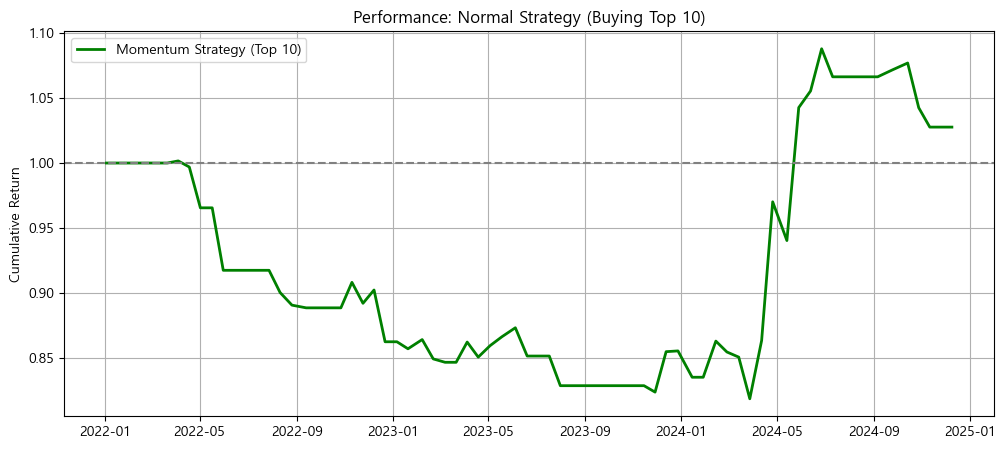

In [3]:
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# [1] 데이터 로드
# =============================================================================
# ★ 아래 경로를 팀 데이터 파일 경로로 수정하세요!
df_raw = pd.read_csv("../단기모멘텀.csv", dtype={'ticker':str})

# (테스트를 위해 빈 변수 선언, 실제 사용시 위 주석을 풀고 실행하세요)
if 'df_raw' not in locals():
    print("⛔ [주의] 데이터가 로드되지 않았습니다. pd.read_csv 코드를 실행해주세요.")
    # 임시 빈 데이터프레임 (에러 방지용)
    df_raw = pd.DataFrame(columns=['date', 'ticker', '종가', '시가', '고가', '저가', '거래량', '등락률'])

# =============================================================================
# [2] 피처 엔지니어링 (과매도/반등 포착 팩터 강화)
# =============================================================================
def make_features_final(df):
    df = df.copy()
    
    # 날짜 변환 및 정렬
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['ticker', 'date'])
    
    print("1. 팩터 생성 중... (Momentum, Volatility, Stochastic, WillR, RSI)")
    
    # --- 1. 추세/변동성 지표 ---
    # F1. 10일 모멘텀 (단기 추세)
    df['F1_MOM_10D'] = df.groupby('ticker')['종가'].pct_change(periods=10)
    
    # F2. 변동성 (10일 표준편차)
    df['F2_VOLATILITY'] = df.groupby('ticker')['등락률'].rolling(10).std().reset_index(0, drop=True)
    
    # F3. 거래량 비율 (3일/10일)
    vol_3d = df.groupby('ticker')['거래량'].rolling(3).mean().reset_index(0, drop=True)
    vol_10d = df.groupby('ticker')['거래량'].rolling(10).mean().reset_index(0, drop=True)
    df['F3_VOL_RATIO'] = vol_3d / (vol_10d + 1e-9)

    # --- 2. 과매도/반등 지표 (핵심) ---
    # F4. 스토캐스틱 (Fast %K)
    n = 14
    low_n = df.groupby('ticker')['저가'].rolling(n).min().reset_index(0, drop=True)
    high_n = df.groupby('ticker')['고가'].rolling(n).max().reset_index(0, drop=True)
    df['F4_Sto_K'] = (df['종가'] - low_n) / (high_n - low_n + 1e-9) * 100
    
    # F5. 윌리엄스 %R
    df['F5_WillR'] = (high_n - df['종가']) / (high_n - low_n + 1e-9) * -100
    
    # F6. 이격도 (20일)
    ma_20 = df.groupby('ticker')['종가'].rolling(20).mean().reset_index(0, drop=True)
    df['F6_Disparity_20'] = df['종가'] / ma_20
    
    # F7. RSI (14일)
    def calc_rsi(x):
        delta = x.diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / (loss + 1e-9)
        return 100 - (100 / (1 + rs))
    df['F7_RSI_14'] = df.groupby('ticker')['종가'].transform(calc_rsi)

    # --- 3. Target 생성 (정답지) ---
    # 학습용: 10일 뒤 수익률의 '등수(Rank)' (0.0 ~ 1.0)
    df['future_return'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
    df['target_rank'] = df.groupby('date')['future_return'].rank(pct=True)
    
    # 백테스트용: 1일 수익률
    df['ret_1d'] = df.groupby('ticker')['종가'].pct_change()
    
    return df

# 팩터 생성 실행
if not df_raw.empty:
    df_processed = make_features_final(df_raw)
else:
    df_processed = pd.DataFrame()

# =============================================================================
# [3] 데이터 분할 및 모델 학습
# =============================================================================
# 모델에 사용할 피처 리스트
features = [
    'F1_MOM_10D', 'F2_VOLATILITY', 'F3_VOL_RATIO', 
    'F4_Sto_K', 'F5_WillR', 'F6_Disparity_20', 'F7_RSI_14'
]

# 결측치 제거
df_clean = df_processed.dropna(subset=['target_rank', 'future_return'] + features)

print("2. 데이터 분할 (Train: ~19년 / Val: 20~21년 / Test: 22년~)")
train_df = df_clean[(df_clean['date'] >= '2015-01-01') & (df_clean['date'] <= '2019-12-31')]
val_df   = df_clean[(df_clean['date'] >= '2020-01-01') & (df_clean['date'] <= '2021-12-31')]
test_df  = df_clean[(df_clean['date'] >= '2022-01-01') & (df_clean['date'] <= '2024-12-31')]

X_train, y_train = train_df[features], train_df['target_rank']
X_val,   y_val   = val_df[features],   val_df['target_rank']
X_test,  y_test  = test_df[features],  test_df['target_rank']

print("3. XGBoost 모델 학습 시작...")
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,    # 안정적인 학습 속도
    max_depth=5,           # 과적합 방지
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

if not X_train.empty:
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    print("   -> 학습 완료!")

# =============================================================================
# [4] 예측 및 결과 데이터셋 구성
# =============================================================================
print("4. Test 데이터 예측 및 랭킹 산출 중...")

if not X_test.empty:
    test_pred = model.predict(X_test)
    
    # 결과 저장 (백테스트에 필요한 컬럼 포함)
    result_df = test_df[['date', 'ticker', '종가', 'ret_1d', 'future_return']].copy()
    result_df.rename(columns={'future_return': 'target_return_10d'}, inplace=True)
    
    result_df['Predicted_Score'] = test_pred 

    # Score(0~100) 및 Rank(1등~N등) 산출
    result_df['Score'] = result_df.groupby('date')['Predicted_Score'].rank(pct=True) * 100
    result_df['Rank'] = result_df.groupby('date')['Predicted_Score'].rank(method='min', ascending=False)
else:
    result_df = pd.DataFrame()

def evaluate_momentum_strategy(df, cost=0.002):
    print(f"\n[🏹 정방향(Momentum) 전략: Top 10 매수]")
    print("=" * 60)
    print(f"   - 매매 주기: 2주(10거래일) 1회")
    print(f"   - 거래 비용: {cost*100}% 적용")
    print(f"   - 손절 매도: -5% 도달 시")
    
    # 1. 시장 지수 (60일 이평선)
    market_trend = df.groupby('date')['종가'].mean()
    market_ma60 = market_trend.rolling(window=60).mean()
    
    # 상승장 여부
    is_bull_market = (market_trend > market_ma60)
    
    dates = df['date'].unique()
    trading_dates = dates[::10] # 2주 1회
    trade_df = df[df['date'].isin(trading_dates)].copy()
    
    stats = []
    
    for date, group in trade_df.groupby('date'):
        # 시장 상황 체크
        try:
            bullish = is_bull_market.loc[date]
            if isinstance(bullish, pd.Series): bullish = bullish.iloc[0]
        except:
            bullish = False

        if not bullish:
            # 하락장 -> 현금 보유
            final_return = 0.0
        else:
            # 상승장 -> 정방향 전략 (Top 10 매수)
            # ★ 핵심 변경: Rank가 1~10등인 상위 10개 선택 (nsmallest)
            selected_stocks = group.nsmallest(10, 'Rank')
            
            # 손절매 로직 (-5%)
            stock_returns = selected_stocks['target_return_10d']
            floored_returns = stock_returns.clip(lower=-0.05)
            
            avg_return = floored_returns.mean()
            final_return = avg_return - cost
            
        stats.append({'date': date, 'Strategy': final_return})
    
    perf_df = pd.DataFrame(stats).set_index('date')
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    
    if len(perf_df) > 0:
        days = (perf_df.index[-1] - perf_df.index[0]).days
        cagr = (1 + total_ret) ** (365 / days) - 1 if days > 0 else 0
    else: cagr = 0
        
    rolling_max = perf_df['Cum_Strategy'].cummax()
    mdd = (perf_df['Cum_Strategy'] / rolling_max - 1).min()

    print(f"1. 누적 수익률 (Total Return) : {total_ret*100:.2f}%")
    print(f"2. 연환산 수익률 (CAGR)       : {cagr*100:.2f}%")
    print(f"3. 최대 낙폭 (MDD)            : {mdd*100:.2f}%")
    print("-" * 60)
    
    plt.figure(figsize=(12, 5))
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label='Momentum Strategy (Top 10)', color='green', linewidth=2)
    plt.axhline(1.0, color='gray', linestyle='--')
    plt.title("Performance: Normal Strategy (Buying Top 10)")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

# 실행
evaluate_momentum_strategy(result_df, cost=0.002)